<a href="https://colab.research.google.com/github/chrishendra93/MI_Workshop/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

In [4]:
np.random.seed(0)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_dir = "/content/drive/MyDrive/Journal Club MIL/mnist_clr"

mnist_columns = ["label"] + ["features_{}".format(i) for i in range(28 ** 2)]
mnist_train = pd.read_csv("./sample_data/mnist_train_small.csv", names=mnist_columns)
mnist_test = pd.read_csv("./sample_data/mnist_test.csv", names=mnist_columns)
mnist_arr_train = mnist_train[["features_{}".format(i) for i in range(28 ** 2)]].values
mnist_arr_test = mnist_test[["features_{}".format(i) for i in range(28 ** 2)]].values

X_train = np.load(os.path.join(root_dir, "train_features.npy"))
X_test = np.load(os.path.join(root_dir, "test_features.npy"))
y_train = np.load(os.path.join(root_dir, "train_labels.npy"))
y_test = np.load(os.path.join(root_dir, "test_labels.npy"))

print(np.all(y_train == mnist_train["label"].values))
print(np.all(y_test == mnist_test["label"].values))



True
True


In [13]:
import copy

def create_bags(mnist_df):
    """
    bags: {key1: [ind1, ind2, ind3],
           key2: [ind1, ind2, ind3, ind4, ind5],
           ... }
    bag_lbls:
        {key1: 0,
         key2: 1,
         ... }
    """
    bags = []
    bag_labels = []
    i = 0
    all_indices, all_labels = np.arange(len(mnist_df)), mnist_df["label"].values
    np.random.shuffle(all_indices)
    all_labels = all_labels[all_indices]
    while i < len(mnist_df):
      bag_size = np.random.randint(3, 7)
      indices = all_indices[i: i + bag_size]
      labels = all_labels[i: i + bag_size]
      bag_labels.append(get_bag_label(labels))
      bags.append(indices)
      i += bag_size
    return np.array(bags), np.array(bag_labels)

def get_bag_label(instance_labels):
  return np.any(instance_labels == 9) * 1


In [14]:
train_bags, train_labels = create_bags(mnist_train)
test_bags, test_labels = create_bags(mnist_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(array([1378.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         843.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

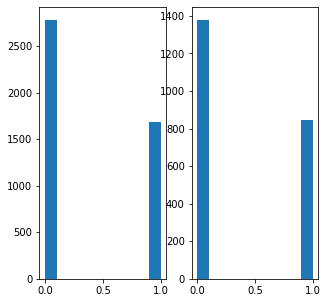

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist(train_labels)
axes[1].hist(test_labels)


(array([  1.,   0., 550.,   0.,   0., 543.,   0., 586.,   0., 541.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <a list of 10 Patch objects>)

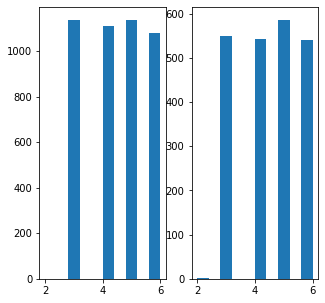

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist([len(bag) for bag in train_bags])
axes[1].hist([len(bag) for bag in test_bags])


In [20]:
print(len(train_bags))
print(len(test_bags))

4461
2221


In [23]:
def visualize_bags(mnist_arr, bags, bag_labels, n_bags):
  pos_bags = np.argwhere(bag_labels == 1).flatten()
  neg_bags = np.argwhere(bag_labels == 0).flatten()
  n_pos = (n_bags // 2 )
  n_neg = n_bags - n_pos
  sampled_indices = np.concatenate([np.random.choice(pos_bags, n_pos, replace=False), np.random.choice(neg_bags, n_neg, replace=False)])
  sampled_bags = bags[sampled_indices]
  sampled_bag_labels = bag_labels[sampled_indices] 
  max_instances_num = np.max([len(bag) for bag in sampled_bags])
  _, axes = plt.subplots(len(sampled_bags), max_instances_num,
                         figsize=(10 * len(sampled_bags), 
                                  10 * max_instances_num))
  for idx, bag, bag_label in zip(np.arange(n_bags), sampled_bags, sampled_bag_labels):
    ax = axes[idx, :]
    instance_size = None
    for i in range(max_instances_num):
      if i >= len(bag):
        ax[i].imshow(np.zeros(instance_size)) # Pad with empty images if bag has fewer instances than max
      else:
        img = mnist_arr[bag[i]]
        if instance_size is None:
          w = int(np.sqrt(len(img)))
          instance_size = (w, w)
        ax[i].imshow(img.reshape(instance_size))
      if i == max_instances_num // 2:
        ax[i].set_title('Bag Label: {}'.format(bag_label), fontsize=50)
  plt.subplots_adjust(bottom=0.1, top=0.3, hspace=0.2)


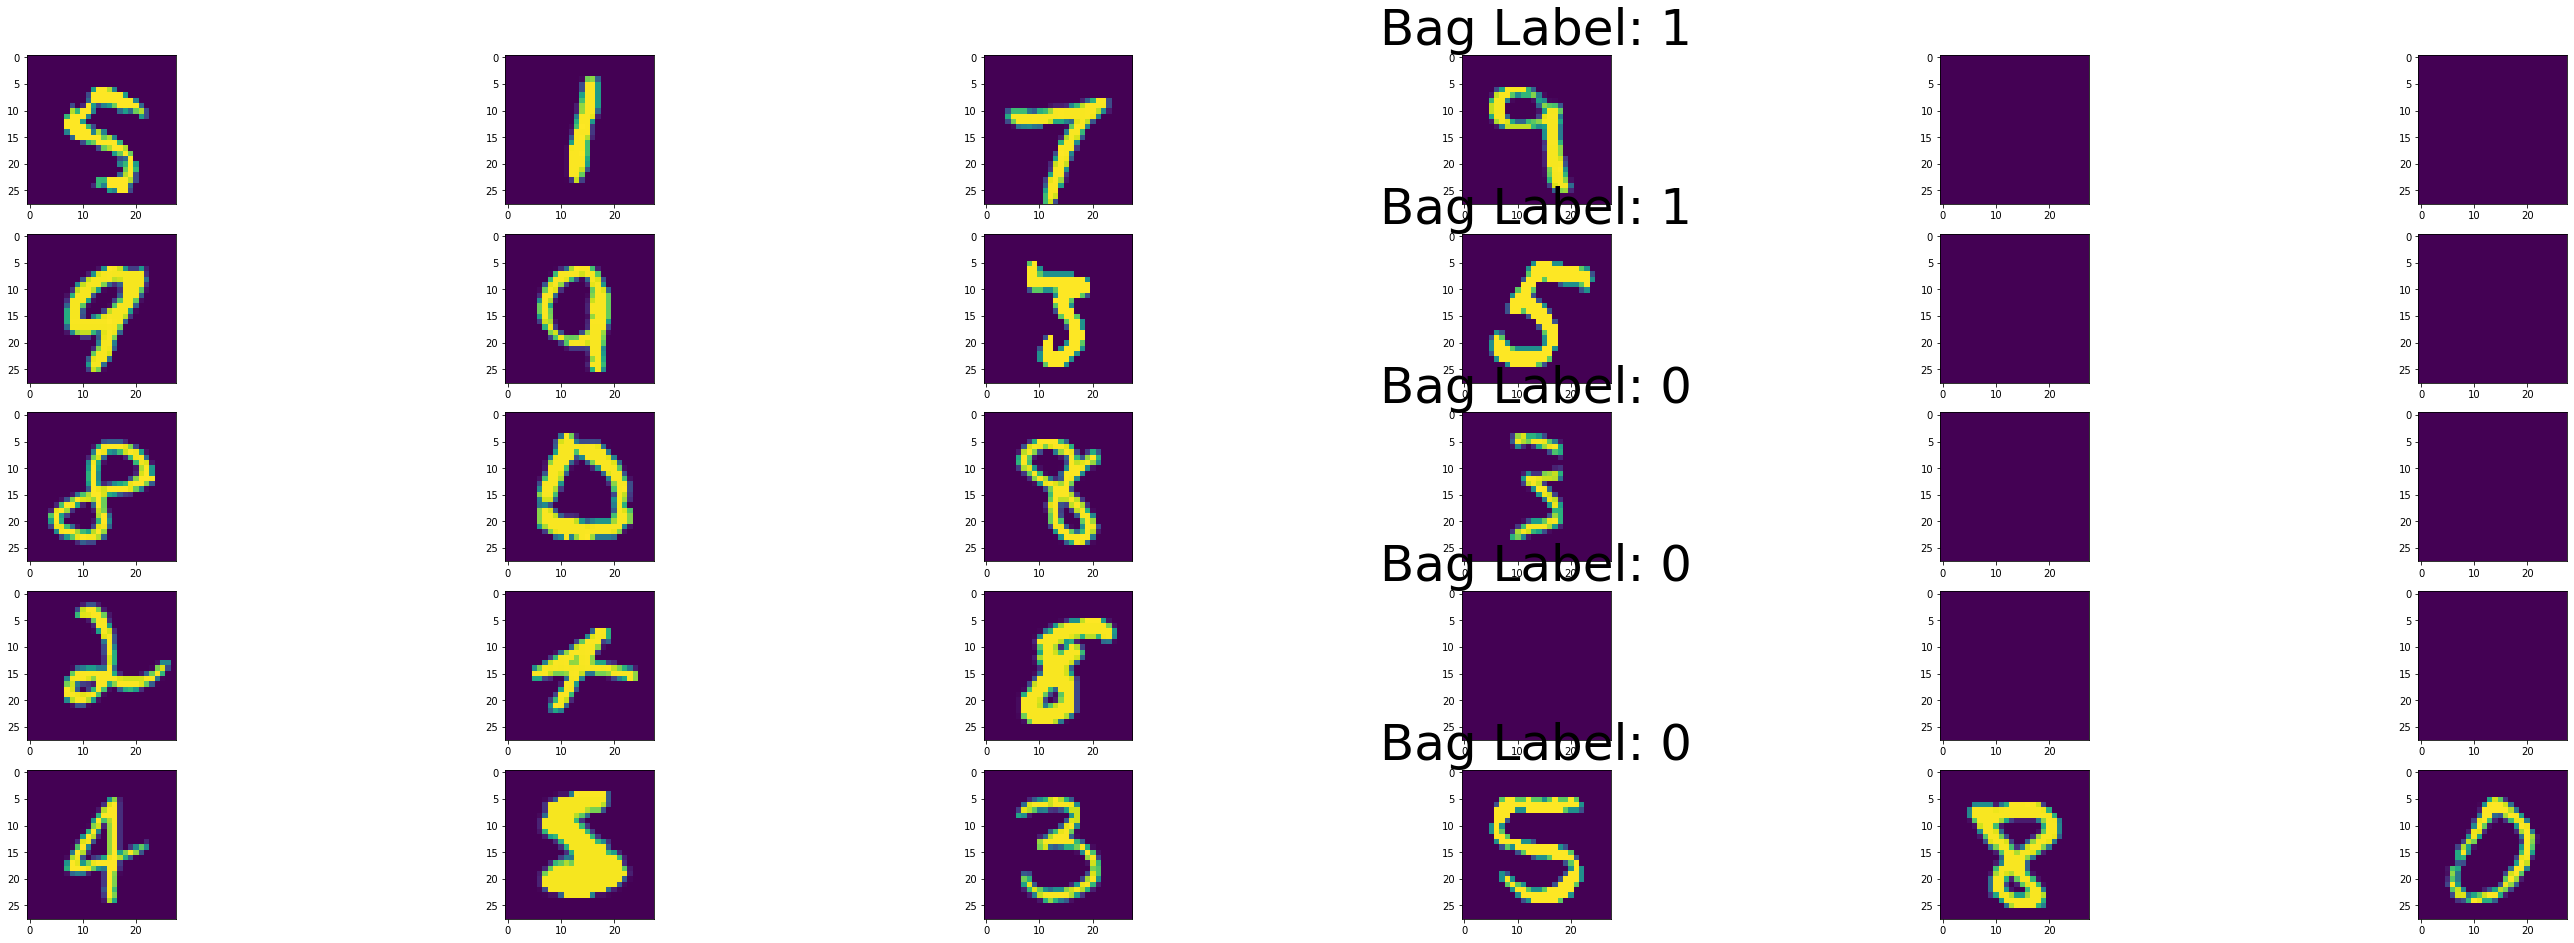

In [24]:
visualize_bags(mnist_arr_train, train_bags, train_labels, 5)

In [25]:
from scipy.stats import kurtosis
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def fetch_instances(mnist_features, indices):
  return mnist_features[indices]

def extract_summary_stats(mnist_features, bags, summary_funcs=[np.mean]):
  summary_stats = []
  for summary_func in summary_funcs:
    summary_func = partial(summary_func, axis=0)
    summary_stat = np.array([summary_func(mnist_features[bag]) for bag in bags]).reshape(-1, 64)
    summary_stats.append(summary_stat)
  return np.concatenate(summary_stats, axis=1)

In [26]:
X_train_stats = extract_summary_stats(X_train, train_bags, [np.mean, np.var, kurtosis])
X_test_stats = extract_summary_stats(X_test, test_bags, [np.mean, np.var, kurtosis])

In [27]:
scaler = StandardScaler().fit(X_train_stats)
pca_obj = PCA().fit(scaler.transform(X_train_stats))
X_train_pca = pca_obj.transform(scaler.transform(X_train_stats))
X_test_pca = pca_obj.transform(scaler.transform(X_test_stats))

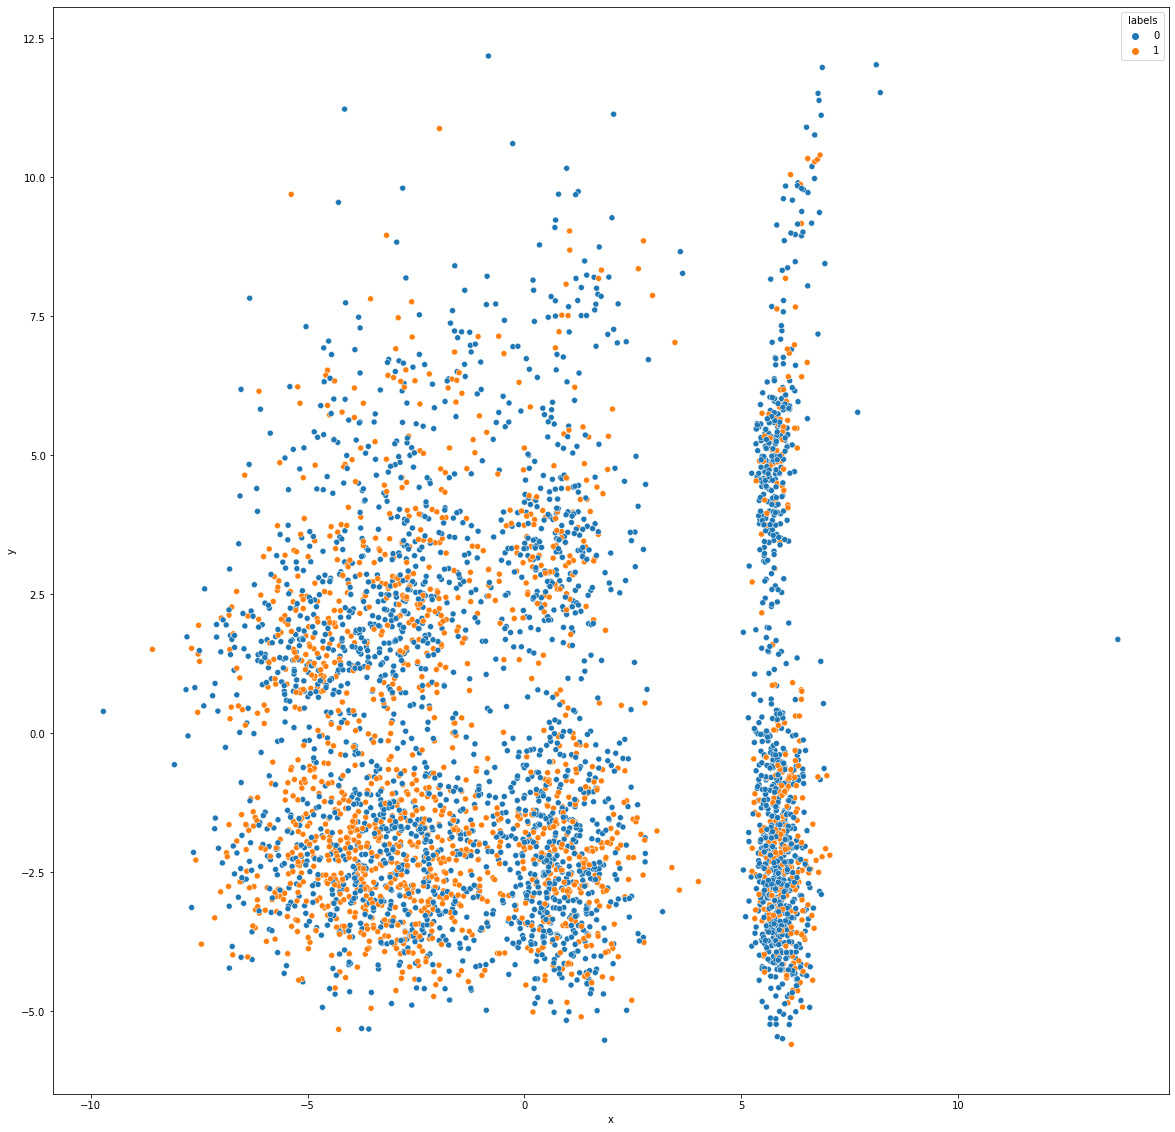

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_train = pd.DataFrame({'x': X_train_pca[:, 0].flatten(), 
                              'y': X_train_pca[:, 1].flatten(),
                              'labels': train_labels})
to_plot_train["labels"] = to_plot_train["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_train, hue='labels', ax=ax)

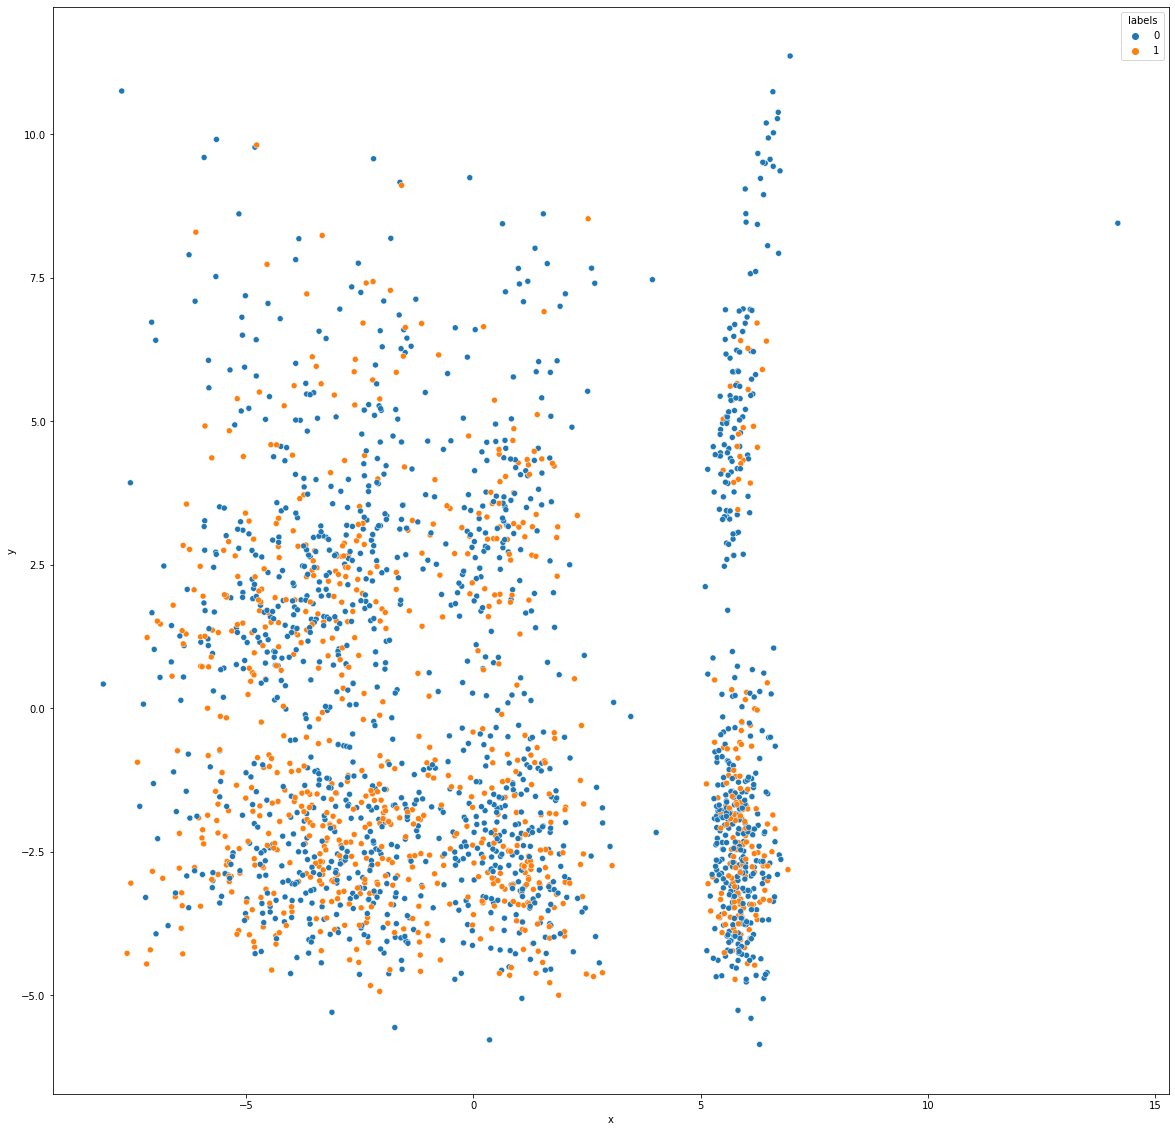

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
to_plot_test = pd.DataFrame({'x': X_test_pca[:, 0].flatten(), 
                              'y': X_test_pca[:, 1].flatten(),
                              'labels': test_labels})
to_plot_test["labels"] = to_plot_test["labels"].astype('category')
sns.scatterplot(x='x', y='y', data=to_plot_test, hue='labels', ax=ax)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
from scipy.stats import mode

In [31]:
def get_roc_auc(y_true, y_pred):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def get_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

In [32]:
summary_statistics_list = {'mean': [np.mean], 'var': [np.var], 'kurtosis': [kurtosis],
                           'mean_var': [np.mean, np.var], 'mean_kurtosis': [np.mean, kurtosis], 'var_kurtosis': [np.var, kurtosis],
                           'mean_var_kurtosis': [np.mean, np.var, kurtosis]}

df = []
for summary_statistics, stats_func in summary_statistics_list.items():

  X_train_stats = extract_summary_stats(X_train, train_bags, stats_func)
  X_test_stats = extract_summary_stats(X_test, test_bags, stats_func)
  model = LogisticRegression(max_iter=10000).fit(X_train_stats, train_labels)
  y_test_pred = model.predict(X_test_stats)
  balanced_accuracy = balanced_accuracy_score(test_labels, y_test_pred)
  roc_auc = get_roc_auc(test_labels, y_test_pred)
  pr_auc = get_pr_auc(test_labels, y_test_pred)
  df += [(summary_statistics, roc_auc, pr_auc, balanced_accuracy)]

df = pd.DataFrame(df, columns=['Model', 'ROC AUC', 'PR AUC', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)
df

,Model,ROC AUC,PR AUC,Balanced Accuracy
3,mean_var,0.772501,0.801170,0.772501
6,mean_var_kurtosis,0.770352,0.792750,0.770352
4,mean_kurtosis,0.769724,0.790637,0.769724
0,mean,0.769040,0.797141,0.769040
5,var_kurtosis,0.545776,0.516072,0.545776
2,kurtosis,0.527250,0.479314,0.527250
1,var,0.500000,0.689779,0.500000


In [36]:
from sklearn.metrics import pairwise_distances

def get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='max', quantile=0.7):
  pairwise_distance = pairwise_distances(X_test, X_train)
  all_bag_distances = []
  
  for test_bag in tqdm(test_bags, total=len(test_bags)):
    test_bag_instances = pairwise_distance[test_bag]
    bag_distances = []

    for train_bag in train_bags:
      if mode == 'max':
        test_train_distance = np.max(np.min(test_bag_instances[:, train_bag], axis=1))
        train_test_distance = np.max(np.min(test_bag_instances[:, train_bag].transpose(), axis=1))
        bag_distances.append(max(test_train_distance, train_test_distance))
      
      elif mode =='avg':
        test_train_distance = np.min(test_bag_instances[:, train_bag], axis=1)
        train_test_distance = np.min(test_bag_instances[:, train_bag].transpose(), axis=1)
        bag_distances.append(np.mean(np.concatenate([train_test_distance, test_train_distance])))
      
      elif mode == 'min':
        test_train_distance = np.min(np.min(test_bag_instances[:, train_bag], axis=1))
        train_test_distance = np.min(np.min(test_bag_instances[:, train_bag].transpose(), axis=1))
        bag_distances.append(max(test_train_distance, train_test_distance))
      elif mode == 'quantile':
        test_train_distance = np.quantile(np.min(test_bag_instances[:, train_bag], axis=1), quantile)
        train_test_distance = np.quantile(np.min(test_bag_instances[:, train_bag].transpose(), axis=1), quantile)
        bag_distances.append(max(test_train_distance, train_test_distance))
    all_bag_distances.append(np.array(bag_distances).reshape(1, -1))
  all_bag_distances = np.concatenate(all_bag_distances, axis=0)
  return all_bag_distances


In [37]:
bag_distances_max = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='max')
bag_distances_avg = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='avg')
bag_distances_min = get_hausdorff_distance(X_train, X_test, train_bags, test_bags, mode='min')

In [38]:
from scipy.stats import mode

def get_knn_pred(train_labels, test_labels, all_bag_distances, n_neighbors):
  return mode(train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_neighbors]], axis=1)[0].flatten()


def get_citation_knn_pred(train_labels, test_labels, all_bag_distances, n_ref_neighbors=10, n_cit_neighbors=10):
  reference_nn = train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_ref_neighbors]]
  num_pos_neighbors = np.sum(reference_nn, axis=1)
  num_neg_neighbors = n_ref_neighbors - num_pos_neighbors
  reference_nn_labels = np.concatenate([num_neg_neighbors.reshape(-1, 1),
                                        num_pos_neighbors.reshape(-1, 1)], axis=1)
  citer_nn_labels = get_citation_counts(train_labels, test_labels, all_bag_distances, n_cit_neighbors)
  return reference_nn_labels + citer_nn_labels

def get_citation_counts(train_labels, test_labels, all_bag_distances, n_neighbors):
  test_pos_neg_counts = np.zeros((len(test_labels), 2))
  nn = np.argsort(all_bag_distances.transpose(), axis=1)[:, :n_neighbors]
  for citer in range(len(nn)):
    citations = nn[citer]
    citer_label = np.array([0, 1]) if train_labels[citer] == 1 else np.array([1, 0])
    for citation in citations:
      test_pos_neg_counts[citation, :] += citer_label
  return test_pos_neg_counts






In [39]:
n_neighbors_ref = 5
n_neighbors_cit = 5

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.761804,0.769005
1,max,0.707914,0.688899
2,min,0.576402,0.607488


In [40]:
n_neighbors_ref = 10
n_neighbors_cit = 5

df_knn = []

for distance_mode, distance in zip(['max', 'avg', 'min'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min]):
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_knn += [(distance_mode, balanced_acc)]
df_knn = pd.DataFrame(df_knn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df_cknn = []

for distance_mode, distance in zip(['max', 'avg', 'min'], 
                          [bag_distances_max, bag_distances_avg, bag_distances_min]):
  y_pred_test_knn = np.argmax(get_citation_knn_pred(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc = balanced_accuracy_score(test_labels, y_pred_test_knn)
  df_cknn += [(distance_mode, balanced_acc)]
df_cknn = pd.DataFrame(df_cknn, columns=['Distance Type', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)

df = df_knn.merge(df_cknn, on=["Distance Type"], suffixes=['_knn', '_cknn'])
df

,Distance Type,Balanced Accuracy_knn,Balanced Accuracy_cknn
0,avg,0.751316,0.776785
1,max,0.685808,0.699778
2,min,0.589520,0.613663


In [41]:
from itertools import permutations

In [42]:
def get_citation_knn_pred_normalized(train_labels, test_labels, all_bag_distances, n_ref_neighbors=10, n_cit_neighbors=10):
  reference_nn = train_labels[np.argsort(all_bag_distances, axis=1)[:, :n_ref_neighbors]]
  num_pos_neighbors = np.sum(reference_nn, axis=1)
  num_neg_neighbors = n_ref_neighbors - num_pos_neighbors
  reference_nn_labels = np.concatenate([num_neg_neighbors.reshape(-1, 1),
                                        num_pos_neighbors.reshape(-1, 1)], axis=1)
  citer_nn_labels = get_citation_counts(train_labels, test_labels, all_bag_distances, n_cit_neighbors)
  return reference_nn_labels / np.sum(reference_nn_labels, axis=0) + citer_nn_labels / np.sum(citer_nn_labels, axis=0)

In [43]:
neighbor_pairs = permutations(np.arange(1, 15), 2)
params_df = []
distance = bag_distances_avg
for pair in tqdm(neighbor_pairs):
  n_neighbors_ref, n_neighbors_cit = pair
  y_pred_test_knn = get_knn_pred(train_labels, test_labels, distance, n_neighbors_ref)
  balanced_acc_knn = balanced_accuracy_score(test_labels, y_pred_test_knn)
  y_pred_test_cknn = np.argmax(get_citation_knn_pred_normalized(train_labels, test_labels, distance, n_neighbors_ref, n_neighbors_cit), axis=1)
  balanced_acc_cknn = balanced_accuracy_score(test_labels, y_pred_test_cknn)
  params_df += [(n_neighbors_ref, n_neighbors_cit, balanced_acc_knn, balanced_acc_cknn)]

params_df = pd.DataFrame(params_df, columns=['N_neighbors_ref', 'N_neighbors_cit', 'Balanced Accuracy KNN', 'Balanced Accuracy Citation-KNN']).sort_values("Balanced Accuracy Citation-KNN", ascending=False)



In [44]:
params_df

,N_neighbors_ref,N_neighbors_cit,Balanced Accuracy KNN,Balanced Accuracy Citation-KNN
155,12,14,0.764071,0.833600
141,11,13,0.778620,0.832553
142,11,14,0.778620,0.832155
178,14,10,0.775375,0.831953
165,13,10,0.782549,0.831095
...,...,...,...,...
7,1,9,0.686925,0.708277
11,1,13,0.686925,0.708047
12,1,14,0.686925,0.707684
9,1,11,0.686925,0.707684


Next we try instance based method, i.e, product rule and sum rule. First we train a classifier to tell whether an instance belongs to a positive or negative bag.

\\
Remember the product rule is given by:

$$p(+|X_i) \propto p(+)^{-(n_i - 1)} \prod_{i=1}^{n_i} p(+|x_{ij})p(x_{ij})$$
$$p(-|X_i) \propto p(-)^{-(n_i - 1)} \prod_{i=1}^{n_i} p(-|x_{ij})p(x_{ij})$$

So essentially we can compute

$$p(+|X_i) = p(+)^{-(n_i - 1)} \prod_{i=1}^{n_i} p(+|x_{ij})$$
$$p(-|X_i)p(-)^{-(n_i - 1)} \prod_{i=1}^{n_i} p(-|x_{ij})$$

and normalize the two so that they sum up to 1. Similarly we can approximate these two quantities using sum-rule and normalize the two quantities given below:

$$p(+|X_i) = (1-n_i)p(+) + \sum_{i=1}^{n_i} p(+|x_{ij})$$
$$p(-|X_i) = (1-n_i)p(-) + \sum_{i=1}^{n_i} p(-|x_{ij})$$


In [45]:
def product_rule(y_instance_proba, pos_prior, neg_prior):
  # This funciton works on one individual bag
  # y_instance proba is of the shape (N_i, 2)

  n_instances = len(y_instance_proba)
  p_neg = (neg_prior) ** (n_instances - 1) * np.product(y_instance_proba[:, 0])
  p_pos = (pos_prior) ** (n_instances - 1) * np.product(y_instance_proba[:, 1])

  return np.array([p_neg, p_pos]) / (p_neg + p_pos)

def sum_rule(y_instance_proba, pos_prior, neg_prior):
  # This funciton works on one individual bag
  # y_instance proba is of the shape (N_i, 2)

  n_instances = len(y_instance_proba)
  p_neg = ((neg_prior) ** (1 - n_instances)) * np.product(y_instance_proba[:, 0])
  p_pos = ((pos_prior) ** (1 - n_instances)) * np.product(y_instance_proba[:, 1])

  return np.array([p_neg, p_pos]) / (p_neg + p_pos)

def sum_rule(y_instance_proba, pos_prior, neg_prior):
  # This funciton works on one individual bag
  # y_instance proba is of the shape (N_i, 2)

  n_instances = len(y_instance_proba)
  p_neg = (1 - n_instances) * (neg_prior) + np.sum(y_instance_proba[:, 0])
  p_pos = (1 - n_instances) * (pos_prior) + np.sum(y_instance_proba[:, 1])

  return np.array([p_neg, p_pos]) / (p_neg + p_pos)

In [47]:
y_train_instance = np.zeros(len(X_train))
for bag, bag_label in zip(train_bags, train_labels):
  y_train_instance[bag] = bag_label
  

In [48]:
instance_classifier = LogisticRegression().fit(X_train, y_train_instance)
y_test_instance_pred = instance_classifier.predict_proba(X_test)

In [49]:
df = []
neg_prior, pos_prior = np.unique(train_labels, return_counts=True)[1] / len(train_labels)

for mode, mi_func in zip(['max', 'mean', 'prod_rule', 'sum_rule'], [np.mean, np.max, product_rule, sum_rule]):
  if mode in ('max', 'mean'):
    y_test_pred_proba = np.concatenate([mi_func(y_test_instance_pred[bag], axis=0).reshape(-1, 2) for bag in test_bags])
  else:
    y_test_pred_proba = np.concatenate([mi_func(y_test_instance_pred[bag], pos_prior, neg_prior).reshape(-1, 2) for bag in test_bags])
  y_test_pred = np.argmax(y_test_pred_proba, axis=1)
  balanced_accuracy = balanced_accuracy_score(test_labels, y_test_pred)
  roc_auc = get_roc_auc(test_labels, y_test_pred)
  pr_auc = get_pr_auc(test_labels, y_test_pred)
  df += [(mode, roc_auc, pr_auc, balanced_accuracy)]

df = pd.DataFrame(df, columns=['Model', 'ROC AUC', 'PR AUC', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)
df

,Model,ROC AUC,PR AUC,Balanced Accuracy
3,sum_rule,0.826775,0.826879,0.826775
1,mean,0.793434,0.828237,0.793434
0,max,0.586721,0.700675,0.586721
2,prod_rule,0.523362,0.692304,0.523362


In [50]:
import torch.nn.functional as F
import torch
from torch import nn
from torch.nn import BCELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

In [51]:
class LogisticRegressionMI(nn.Module):

  def __init__(self, n_dim, mode='max'):
    super(LogisticRegressionMI, self).__init__()
    if mode not in ('max', 'mean'):
      raise ValueError("Invalid mode {}, must be one of max or mean".format(mode))
    self.mode = mode
    self.encoder = nn.Linear(n_dim, 1)
    
  def forward(self, x, indices):
    x = self.encoder(x)
    x = torch.sigmoid(x)
    if self.mode == 'max':
      x = torch.stack([torch.max(x[idx]) for idx in indices])
    else:
      x = torch.stack([torch.mean(x[idx]) for idx in indices])
    return x
  
  def get_max_indices(self, x, indices):
    x = self.encoder(x)
    x = torch.sigmoid(x)
    pred, max_indices = [], []
    for idx in indices:
      max_idx = torch.argmax(x[idx])
      max_indices.append(idx[max_idx])
      pred.append(x[idx][max_idx])
    return torch.cat(pred), np.array(max_indices)


class DiverseDensity(nn.Module):

  def __init__(self, n_dim):
    super(DiverseDensity, self).__init__()
    self.prototype = torch.nn.Parameter(F.normalize(torch.randn(n_dim), dim=0))
    
  def forward(self, x, indices):
    x = torch.exp(-torch.sum((self.prototype - x) ** 2, axis=1))
    x = torch.stack([1 - torch.prod(1 - x[idx]) for idx in indices])
    return x
  
  def get_likelihood(self, x, labels, indices):
    eps = torch.Tensor([1e-5])
    neg_indices, pos_indices = np.argwhere(labels == 0).flatten(), np.argwhere(labels == 1).flatten()
    x = torch.exp(-torch.sum((self.prototype - x) ** 2, axis=1)) # This value will be high if x is close to the prototype

    # neg_ll = -torch.prod(torch.stack([torch.prod(1 - x[indices[idx]]) for idx in neg_indices]))
    # pos_ll = -torch.prod(torch.stack([1 - torch.prod(1 - x[indices[idx]]) for idx in pos_indices]))
      
    neg_ll = -torch.sum(torch.stack([torch.sum(torch.log(1 - x[indices[idx]] + eps)) for idx in neg_indices]))
    pos_ll = -torch.sum(torch.stack([torch.log(1 - torch.prod(1 - x[indices[idx]] + eps)) for idx in pos_indices]))
    return neg_ll + pos_ll

In [52]:
logit_mi = LogisticRegressionMI(64, mode='max')
criterion = BCELoss()
optimizer = LBFGS(logit_mi.parameters(), lr=0.001, max_iter=1000)
logit_mi.train()


def closure():
    optimizer.zero_grad()
    output = logit_mi(torch.Tensor(X_train), train_bags)
    loss = criterion(output, torch.Tensor(train_labels))
    loss.backward()
    return loss

optimizer.step(closure) 

logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test = logit_mi(torch.Tensor(X_test), test_bags).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.9397996305268178
PR AUC: 0.8988678062722641
Accuracy Score: 0.8811346240432237
Balanced Accuracy Score: 0.8689769070652708


In [53]:
dd = DiverseDensity(64)
criterion = BCELoss()
optimizer = LBFGS(dd.parameters(), lr=0.001, max_iter=1000)
dd.train()


def closure():
    optimizer.zero_grad()
    output = dd(torch.Tensor(X_train), train_bags)
    loss = criterion(output, torch.Tensor(train_labels))
    loss.backward()
    return loss

optimizer.step(closure) 

dd.eval()
with torch.no_grad():
  y_pred_dd = dd(torch.Tensor(X_test), test_bags).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_dd)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_dd)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_dd >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_dd >= 0.5)))

ROC AUC: 0.8819338632673758
PR AUC: 0.8283613708616171
Accuracy Score: 0.7784781629896443
Balanced Accuracy Score: 0.7210804594139046


In [54]:
dd = DiverseDensity(64)
criterion = BCELoss()
optimizer = LBFGS(dd.parameters(), lr=0.001, max_iter=1000)
dd.train()


def closure():
    optimizer.zero_grad()
    loss = dd.get_likelihood(torch.Tensor(X_train), train_labels, train_bags)
    loss.backward()
    return loss

optimizer.step(closure) 

dd.eval()
with torch.no_grad():
  y_pred_dd = dd(torch.Tensor(X_test), test_bags).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_dd)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_dd)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_dd >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_dd >= 0.5)))

ROC AUC: 0.8877772555339197
PR AUC: 0.8372957314390039
Accuracy Score: 0.7874831157136425
Balanced Accuracy Score: 0.732252030294735


In [55]:
logit_mi = LogisticRegressionMI(64, mode='max')
criterion = BCELoss()
optimizer = LBFGS(logit_mi.parameters(), lr=0.001, max_iter=1000)
logit_mi.train()


def closure():
    optimizer.zero_grad()
    output = logit_mi(torch.Tensor(X_train), train_bags)
    loss = criterion(output, torch.Tensor(train_labels))
    loss.backward()
    return loss

optimizer.step(closure) 

logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test = logit_mi(torch.Tensor(X_test), test_bags).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.9453959612759049
PR AUC: 0.9155966037102555
Accuracy Score: 0.880234128770824
Balanced Accuracy Score: 0.8705539687376792


In [56]:
state_dict = logit_mi.state_dict()



In [ ]:
logit_mi = LogisticRegressionMI(64, mode='max')
logit_mi.load_state_dict(state_dict)

<All keys matched successfully>

In [58]:
logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test, max_indices = logit_mi.get_max_indices(torch.Tensor(X_test), test_bags)
  y_pred_logit_mi_test, max_indices = y_pred_logit_mi_test.detach().cpu().numpy(), max_indices
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.9453959612759049
PR AUC: 0.9155966037102555
Accuracy Score: 0.880234128770824
Balanced Accuracy Score: 0.8705539687376792


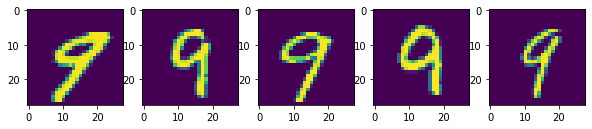

In [59]:
pos_preds = (y_pred_logit_mi_test >= 0.5)
pos_max_indices = max_indices[pos_preds]
indices = np.random.choice(len(pos_max_indices), 5)
fig, axes = plt.subplots(1, 5, figsize=(10, 50))
for idx, ax in zip(indices, axes):
  ax.imshow(mnist_arr_test[pos_max_indices][idx].reshape(28, 28))

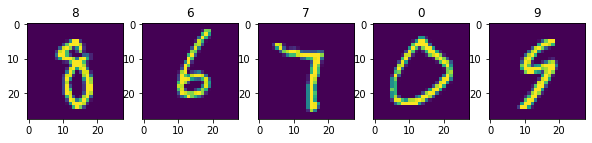

In [63]:
neg_preds = (y_pred_logit_mi_test < 0.5)

neg_max_indices = max_indices[neg_preds]
indices = np.random.choice(len(neg_max_indices), 5)
fig, axes = plt.subplots(1, 5, figsize=(10, 50))
for idx, ax in zip(indices, axes):
  ax.imshow(mnist_arr_test[neg_max_indices][idx].reshape(28, 28))
  ax.set_title(y_test[neg_max_indices][idx])

In [64]:
np.save("train_labels.npy", train_labels)
np.save("train_bags.npy", train_bags)

np.save("test_labels.npy", test_labels)
np.save("test_bags.npy", test_bags)


In [65]:
from google.colab import files

files.download('train_bags.npy') 
files.download('train_labels.npy') 

files.download('test_bags.npy') 
files.download('test_labels.npy') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>